In [1]:
using DrWatson
@quickactivate "momdist"

In [2]:
using PersistenceDiagrams, PersistenceDiagramsBase, Ripserer
using Distributions, Distances, JLD2, LinearAlgebra, Parameters, Pipe, Plots
using LazySets, LambertW, ProgressMeter, Random, Statistics, StatsPlots

import RobustTDA as rtda

plot_par = rtda.plot_params(alpha=0.3)
theme(:dao)

┌ Info: Precompiling RobustTDA [0486e2d6-2f70-4752-bbcc-413e24845f5e]
└ @ Base loading.jl:1423
┌ Warning: Package RobustTDA does not have ProgressMeter in its dependencies:
│ - If you have RobustTDA checked out for development and have
│   added ProgressMeter as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with RobustTDA
└ Loading ProgressMeter into RobustTDA from project dependency, future warnings for RobustTDA are suppressed.


In [3]:
function randomRotation(; d=3)
    A = randn(d, d)
    M = (A + A') ./ √2
    _, U = eigen(M)
    return U
end

function interlockedCircles(n; args...)
    R = [1 0 0; 0 0 -1; 0 1 0]
    X1 = [[x...; 0] for x in rtda.randCircle(n)]
    X2 = [R * ([x...; 0] .+ [1.0, 0.0, 0.0]) for x in rtda.randCircle(n)]
    return [X1; X2]
end

interlockedCircles (generic function with 1 method)

In [4]:
begin
    Random.seed!(2022)
    m = 150
    n = 7 * m
    dim = 100
    R = randomRotation(d=dim)

    points = interlockedCircles(n)
    signal = [Tuple(R * [x...; zeros(dim - 3)]) for x in points]

    l = 1
    win = (-l, l, -l, l)
    R = product_distribution(repeat([Uniform(-1, 1)], dim))
    noise = [rand(R) for _ in 1:m]

    X = [signal; noise]
    Xn = [[x...] for x in X]
end;

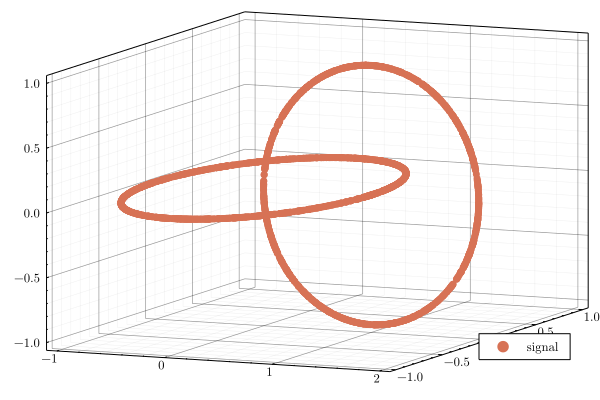

In [5]:
scatter(Tuple.(points), ratio=1, label="signal", legend=:bottomright)

In [6]:
# Initialize Lepski Parameters
θ = rtda.lepski_params(
    a=0.1,
    b=1,
    mmin=100,
    mmax=500,
    pi=1.12,
    δ=0.02
)

# Calibration
M = rtda.lepski(Xn=Xn, params=θ)

┌ Warning: ProgressMeter by default refresh meters with additional information in IJulia via `IJulia.clear_output`, which clears all outputs in the cell. 
│  - To prevent this behaviour, do `ProgressMeter.ijulia_behavior(:append)`. 
│  - To disable this warning message, do `ProgressMeter.ijulia_behavior(:clear)`.
└ @ ProgressMeter /storage/home/s/suv87/work/julia_depot/packages/ProgressMeter/sN2xr/src/ProgressMeter.jl:618
Progress:  84%|██████████████████████████████████▎      |  ETA: 0:02:57
  m:  248

248

In [ ]:
# Refined Lepski
θ = rtda.lepski_params(
    a=0.2,
    b=1,
    mmin=round(Int, 0.5 * M),
    mmax=round(Int, 1 * M),
    pi=1.07,
    δ=0.01
)
M = rtda.lepski(Xn=Xn, params=θ)

In [ ]:
theme(:default)

In [ ]:
Q = 2 * M + 1
dnq = rtda.momdist(Xn, floor(Int, Q))
w_momdist = rtda.fit(Xn, dnq)
D1 = rtda.wrips(Xn, w=w_momdist, p=1)

In [ ]:
plot(D1[2], title="MoM")

In [ ]:
dnm = rtda.dtm(Xn, Q / n)
w_dtm = rtda.fit(Xn, dnm)
D2 = rtda.wrips(Xn, w=w_dtm, p=1)

In [ ]:
plot(D2[2], title="DTM")